In [152]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
color = sns.color_palette()

In [153]:
RAW_DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data'
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data'
TRAIN_DATA = os.path.join(RAW_DATA_PATH, 'train.csv')
TEST_DATA = os.path.join(RAW_DATA_PATH, 'test.csv')
SAMPLE_SUBMISSION = os.path.join(RAW_DATA_PATH, 'sample_submission.csv')
SUBMISSION_PATH = os.path.join(DATA_PATH, 'submissions')
MODELS_PATH = os.path.join(DATA_PATH, 'models')

In [154]:
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION)

In [155]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [156]:
test_df.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [147]:
sample_submission_df.head()

,ID,y
0,1,100.669318
1,2,100.669318
2,3,100.669318
3,4,100.669318
4,5,100.669318


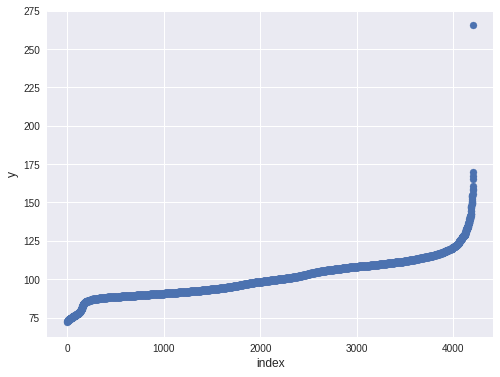

In [61]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

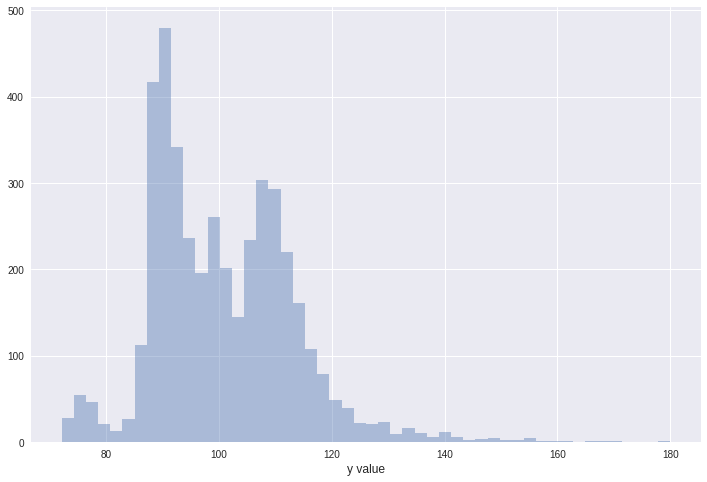

In [6]:
ulimit = 180
train_df.loc[train_df.y > ulimit, 'y'] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize=12)
plt.show()

In [134]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,365
1,float64,1


In [16]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,column_name,missing_count


In [122]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [113]:
unique_values_dict = {}
for col in train_df.columns:
    if col not in ["ID", "y", "X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]:
        unique_value = str(np.sort(train_df[col].unique()).tolist())
        tlist = unique_values_dict.get(unique_value, [])
        tlist.append(col)
        unique_values_dict[unique_value] = tlist
for unique_val, columns in unique_values_dict.items():
    print("Columns containing the unique values : ",unique_val)
    print(columns)
    print("--------------------------------------------------")

Columns containing the unique values :  [0]
['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
--------------------------------------------------
Columns containing the unique values :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 

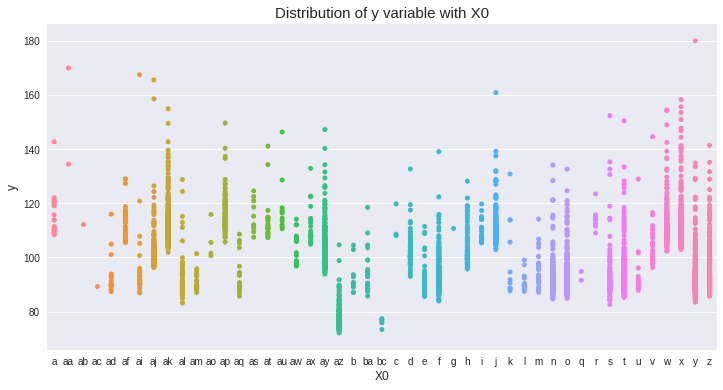

In [12]:
col = 'X0'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
ax = sns.stripplot(x=col, y="y", data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

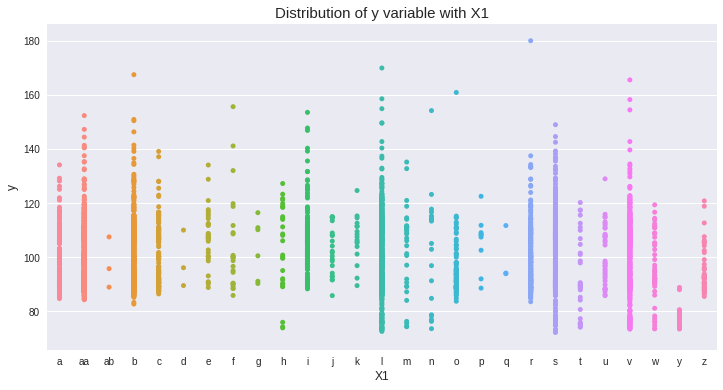

In [13]:
col = 'X1'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
ax = sns.stripplot(x=col, y="y", data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

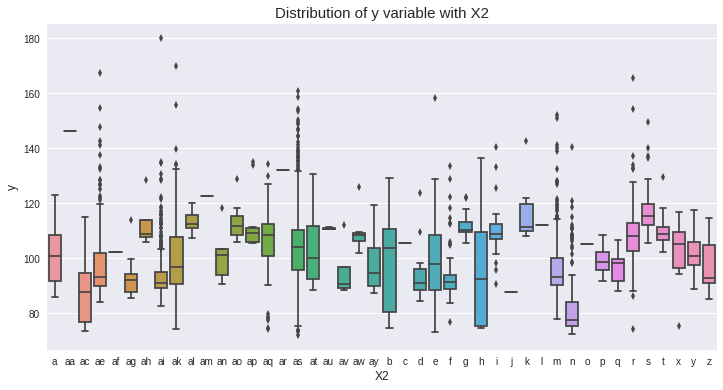

In [14]:
col = 'X2'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

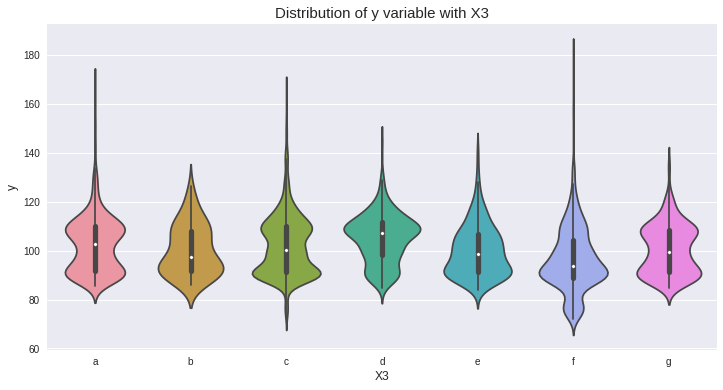

In [15]:
col = 'X3'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

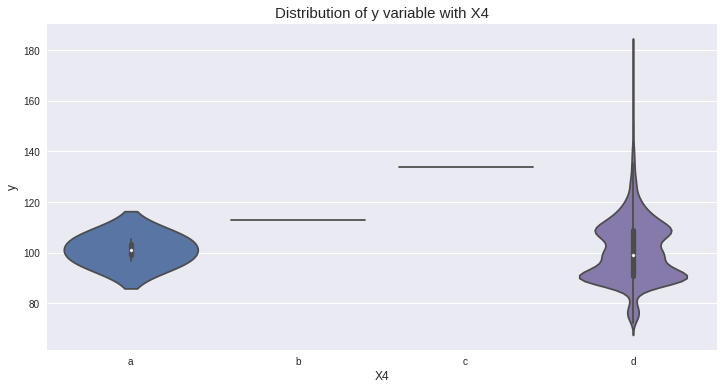

In [16]:
col = 'X4'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.violinplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

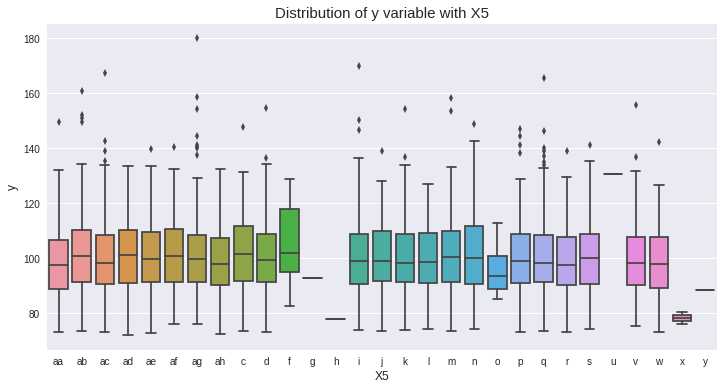

In [20]:
col = 'X5'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

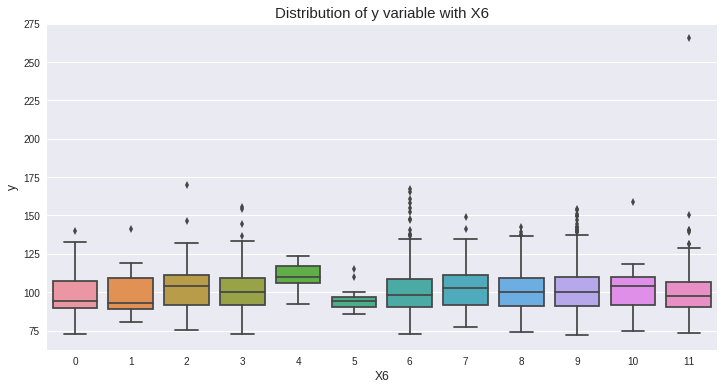

In [22]:
col = 'X6'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

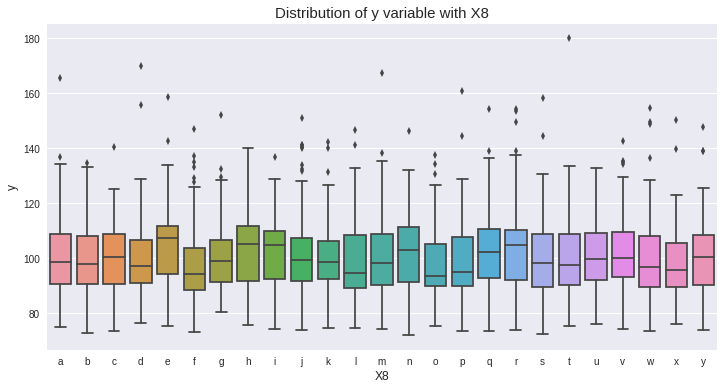

In [22]:
col = 'X8'
col_values_sorted = np.sort(train_df[col].unique()).tolist()
plt.figure(figsize=(12,6))
sns.boxplot(x=col, y='y', data=train_df, order=col_values_sorted)
plt.xlabel(col, fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title("Distribution of y variable with " + col, fontsize=15)
plt.show()

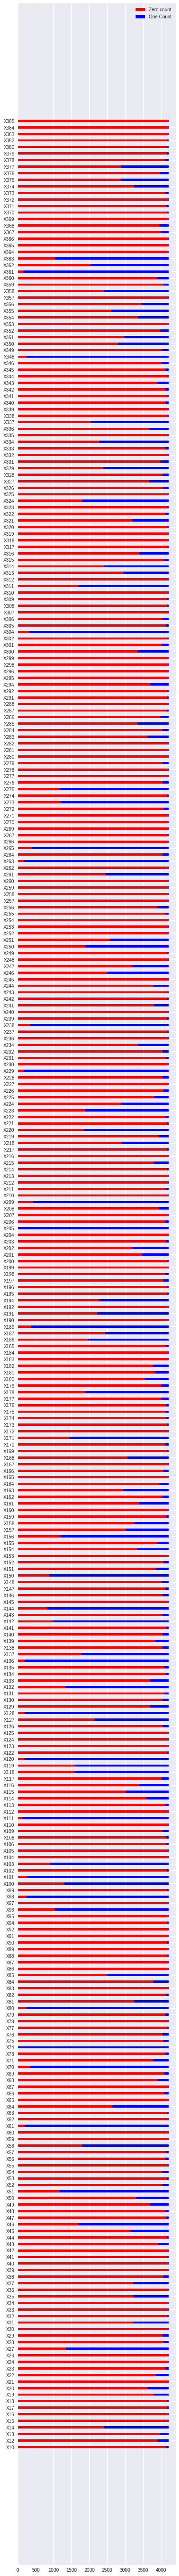

In [23]:
zero_count_list = []
one_count_list = []
cols_list = unique_values_dict['[0, 1]']
for col in cols_list:
    zero_count_list.append((train_df[col]==0).sum())
    one_count_list.append((train_df[col]==1).sum())

N = len(cols_list)
ind = np.arange(N)
width = 0.35

plt.figure(figsize=(6,100))
p1 = plt.barh(ind, zero_count_list, width, color='red')
p2 = plt.barh(ind, one_count_list, width, left=zero_count_list, color="blue")
plt.yticks(ind, cols_list)
plt.legend((p1[0], p2[0]), ('Zero count', 'One Count'))
plt.show()

In [24]:
zero_mean_list = []
one_mean_list = []
cols_list = unique_values_dict['[0, 1]']
for col in cols_list:
    zero_mean_list.append(train_df.loc[train_df[col]==0, 'y'].mean())
    one_mean_list.append(train_df.loc[train_df[col]==1, 'y'].mean())

new_df = pd.DataFrame({"column_name":cols_list+cols_list, "value":[0]*len(cols_list) + [1]*len(cols_list), "y_mean":zero_mean_list+one_mean_list})
new_df

,column_name,value,y_mean
0,X10,0,100.688500
1,X12,0,100.323075
2,X13,0,100.495972
3,X14,0,98.509709
4,X15,0,100.642648
5,X16,0,100.617230
6,X17,0,100.826232
7,X18,0,100.650903
8,X19,0,101.381272
9,X20,0,101.137993


In [25]:
new_df2 = new_df.pivot('column_name', 'value', 'y_mean')
new_df2

value,0,1
column_name,,
X10,100.688500,97.723214
X100,99.763083,101.046740
X101,110.198376,99.991894
X102,100.586823,109.617931
X103,100.472172,100.697632
X104,100.636051,107.473750
X105,100.645061,102.323000
X106,100.721623,95.167636
X108,100.987507,78.010484


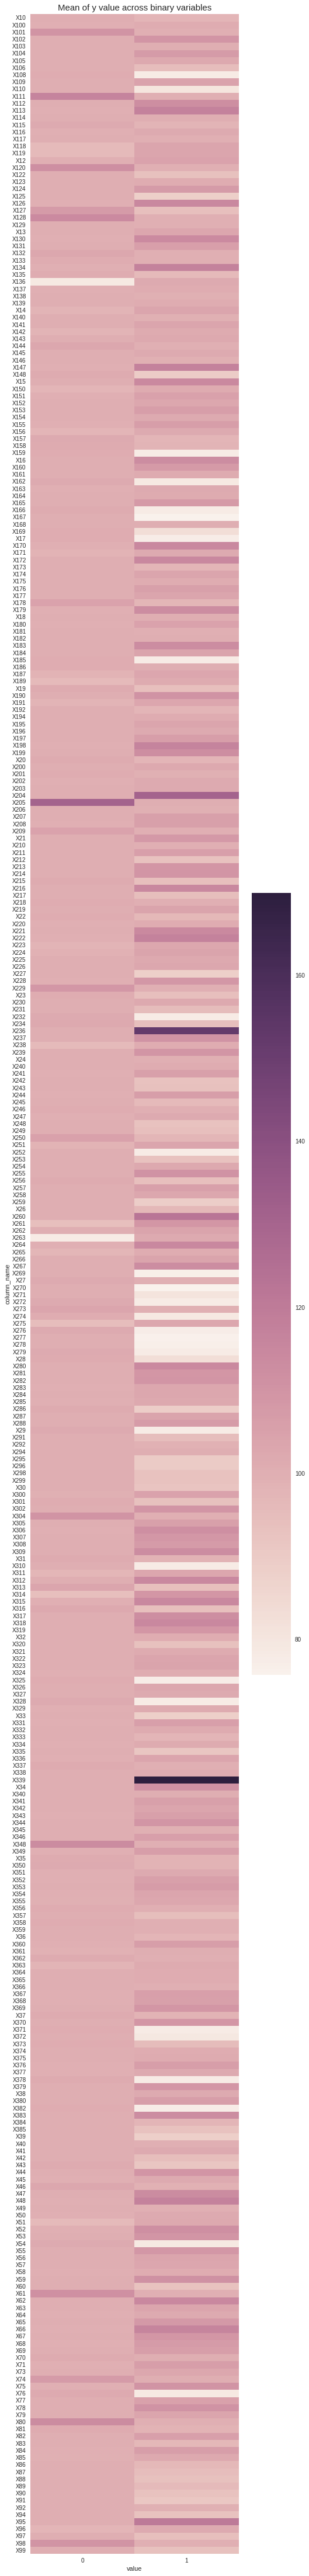

In [26]:
plt.figure(figsize=(8,80))
sns.heatmap(new_df2)
plt.title("Mean of y value across binary variables", fontsize=15)
plt.show()